| Action | Time | Notes|
|  ----  |  --- |  --- |
| Open Remote Dataset (fsspec + xarray) | 32.9s | Use `simple_templates=True` |
| Plotting + animation | 1min 46s | |

***

In [2]:
from IPython.display import HTML

In [3]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import s3fs
import datetime as dt
import zipfile
import logging
import fsspec
import ujson
from tqdm import tqdm
from glob import glob
import os

from azure.storage.blob import ContainerClient
import tempfile
from metpy import xarray

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import pandas as pd

In [4]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:39145 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 4 Memory: 32.00 GiB


In [5]:
%%time
fs = fsspec.filesystem('reference', fo='combined.json', remote_protocol='az', remote_options={'account_name':'goeseuwest'}, simple_templates=True)

m = fs.get_mapper("")

ds = xr.open_dataset(m, engine='zarr', chunks='auto')

CPU times: user 31.4 s, sys: 1.84 s, total: 33.2 s
Wall time: 32.7 s


## Lat/lon

In [6]:
def calc_latlon(ds):
    # The math for this function was taken from 
    # https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm 

    x = ds.x
    y = ds.y
    goes_imager_projection = ds.goes_imager_projection
    
    x,y = np.meshgrid(x,y)
    
    r_eq = goes_imager_projection.attrs["semi_major_axis"]
    r_pol = goes_imager_projection.attrs["semi_minor_axis"]
    l_0 = goes_imager_projection.attrs["longitude_of_projection_origin"] * (np.pi/180)
    h_sat = goes_imager_projection.attrs["perspective_point_height"]
    H = r_eq + h_sat
    
    a = np.sin(x)**2 + (np.cos(x)**2 * (np.cos(y)**2 + (r_eq**2 / r_pol**2) * np.sin(y)**2))
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - r_eq**2
    
    r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)
    
    s_x = r_s * np.cos(x) * np.cos(y)
    s_y = -r_s * np.sin(x)
    s_z = r_s * np.cos(x) * np.sin(y)
    
    lat = np.arctan((r_eq**2 / r_pol**2) * (s_z / np.sqrt((H-s_x)**2 +s_y**2))) * (180/np.pi)
    lon = (l_0 - np.arctan(s_y / (H-s_x))) * (180/np.pi)
    
    ds = ds.assign_coords({
        "lat":(["y","x"],lat),
        "lon":(["y","x"],lon)
    })
    ds.lat.attrs["units"] = "degrees_north"
    ds.lon.attrs["units"] = "degrees_east"

    return ds

In [7]:
def get_xy_from_latlon(ds, lats, lons):
    lat1, lat2 = lats
    lon1, lon2 = lons

    lat = ds.lat.data
    lon = ds.lon.data
    
    x = ds.x.data
    y = ds.y.data
    
    x,y = np.meshgrid(x,y)
    
    x = x[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)]
    y = y[(lat >= lat1) & (lat <= lat2) & (lon >= lon1) & (lon <= lon2)] 
    
    return ((min(x), max(x)), (min(y), max(y)))


In [8]:
ds = calc_latlon(ds)

<ipython-input-6-faaad4e12a01>:21: RuntimeWarning: invalid value encountered in sqrt
  r_s = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)


In [9]:
top = 49.3457868 # north lat
left = -124.7844079 # west long
right = -66.9513812 # east long
bottom =  24.7433195 # south lat

lats = (bottom, top)
lons = (left, right)

((x1, x2), (y1,y2)) = get_xy_from_latlon(ds, lats, lons)

In [10]:
%%time
subset = ds.sel(x=slice(x1, x2), y=slice(y2,y1))
subset

CPU times: user 19.6 ms, sys: 336 µs, total: 19.9 ms
Wall time: 18 ms


<xarray.Dataset>
Dimensions:                                 (band: 1, number_of_image_bounds: 2, number_of_time_bounds: 2, t: 144, x: 2440, y: 1020)
Coordinates: (12/39)
    band_id_C01                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C02                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C03                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C04                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C05                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    band_id_C06                             (band) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ...                                      ...
  * x                                       (x) float32 -0.1144 ... 0.0222
    x_image                                 float32 ...
  * y                                       (y) float32 0.126 0.126 ... 0.06896
    y_image                                 float32 ...
    lat                                     (y, x) float32 nan nan ... 23.34
    lon                                     (y, x) float32 nan nan ... -67.06
Dimensions without coordinates: band, number_of_image_bounds, number_of_time_bounds
Data variables: (12/124)
    CMI_C01                                 (t, y, x) float32 dask.array<chunksize=(8, 1020, 1139), meta=np.ndarray>
    CMI_C02                                 (t, y, x) float32 dask.array<chunksize=(8, 1020, 1139), meta=np.ndarray>
    CMI_C03                                 (t, y, x) float32 dask.array<chunksize=(8, 1020, 1139), meta=np.ndarray>
    CMI_C04                                 (t, y, x) float32 dask.array<chunksize=(8, 1020, 1139), meta=np.ndarray>
    CMI_C05                                 (t, y, x) float32 dask.array<chunksize=(8, 1020, 1139), meta=np.ndarray>
    CMI_C06                                 (t, y, x) float32 dask.array<chunksize=(8, 1020, 1139), meta=np.ndarray>
    ...                                      ...
    std_dev_reflectance_factor_C04          (t) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    std_dev_reflectance_factor_C05          (t) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    std_dev_reflectance_factor_C06          (t) float32 dask.array<chunksize=(144,), meta=np.ndarray>
    time_bounds                             (t, number_of_time_bounds) datetime64[ns] dask.array<chunksize=(144, 2), meta=np.ndarray>
    x_image_bounds                          (number_of_image_bounds) float32 dask.array<chunksize=(2,), meta=np.ndarray>
    y_image_bounds                          (number_of_image_bounds) float32 dask.array<chunksize=(2,), meta=np.ndarray>
Attributes: (12/29)
    Conventions:               CF-1.7
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    cdm_data_type:             Image
    dataset_name:              OR_ABI-L2-MCMIPF-M6_G16_s20200020000216_e20200...
    date_created:              2020-01-02T00:10:03.1Z
    id:                        087244ef-58ee-4c60-a351-2d8b63086250
    ...                        ...
    standard_name_vocabulary:  CF Standard Name Table (v35, 20 July 2016)
    summary:                   Multiple reflectance and emissive channel Clou...
    time_coverage_end:         2020-01-02T00:09:52.4Z
    time_coverage_start:       2020-01-02T00:00:21.6Z
    timeline_id:               ABI Mode 6
    title:                     ABI L2 Cloud and Moisture Imagery

### Calculate true color
https://unidata.github.io/python-gallery/examples/mapping_GOES16_TrueColor.html

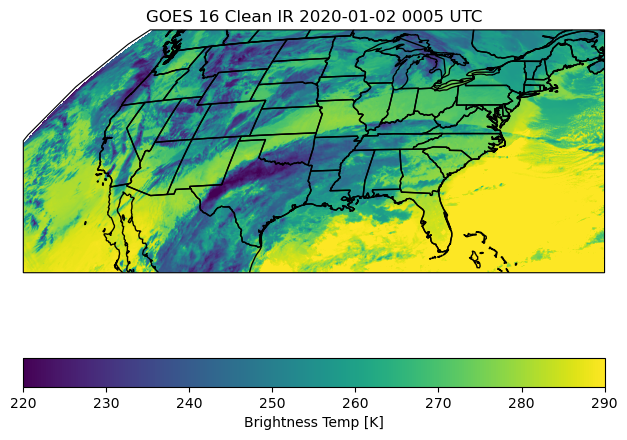

In [13]:
nt = len(subset.t)

from matplotlib.animation import FuncAnimation

fig = plt.figure(figsize=(7.5,7.5), dpi=100)

dummy_channel = subset.metpy.parse_cf('CMI_C01')
x = dummy_channel.x; y = dummy_channel.y
ax = fig.add_subplot(111, projection = dummy_channel.metpy.cartopy_crs)

p = ax.imshow(subset.CMI_C13.isel(t=0), origin='upper', extent=(x.min(), x.max(), y.min(), y.max()),
         vmin=220, vmax=290)
ax.coastlines()
ax.add_feature(ccrs.cartopy.feature.BORDERS)
ax.add_feature(ccrs.cartopy.feature.STATES)

ts = pd.to_datetime(str(subset.t[0].values)).strftime("%Y-%m-%d %H%M UTC")
ax.set_title(f"GOES 16 Clean IR {ts}")
plt.colorbar(p, orientation='horizontal', label='Brightness Temp [K]', ax=ax)


def update_anim(i):
    ts = pd.to_datetime(str(subset.t[i].values)).strftime("%Y-%m-%d %H%M UTC")
    
    ax.clear()
    
    p = ax.imshow(subset.CMI_C13.isel(t=i), origin='upper', extent=(x.min(), x.max(), y.min(), y.max()),
                 vmin=220, vmax=290)
    ax.set_title(f"GOES 16 Clean IR {ts}")
    ax.coastlines()
    ax.add_feature(ccrs.cartopy.feature.BORDERS)
    ax.add_feature(ccrs.cartopy.feature.STATES)
#     plt.colorbar(p, orientation='horizontal', label='Brightness Temperature [K]', ax=ax)
    

    return p
  
# update_anim(1)
animator = FuncAnimation(fig, update_anim, frames=nt, interval=50)
# plt.show()

In [14]:
%time HTML(animator.to_html5_video())

CPU times: user 1min 3s, sys: 2.82 s, total: 1min 6s
Wall time: 1min 46s
